## Design Your Model

We provide some simple prototypes RLinear, RMLP, and STD in `./models` for agile study. Taking a simplified [MLP-Mixer](https://arxiv.org/abs/2105.01601) as an example, the following code shows how to design and extend your model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from layers.Invertible import RevIN

class Model(nn.Module):
    def __init__(self, channel, d_model, seq_len, pred_len):
        super(Model, self).__init__()
        # Temporal mixing, you can choose any type of extractor such as Attention, Convolution, and etc.
        self.temporal = nn.Sequential(
            nn.Linear(seq_len, d_model),
            nn.GELU(),
            nn.Linear(d_model, seq_len)
        )
        # Channel mixing, you can choose any type of extractor such as MLP, GNN, and etc.
        self.channel = nn.Sequential(
            nn.Linear(channel, d_model),
            nn.GELU(),
            nn.Linear(d_model, channel)
        )
        self.projection = nn.Linear(seq_len, pred_len)
        self.rev = RevIN(channel)
        self.apply(self._init_weights)

        # Frozen randomly initialized parameters in temporal feature extractor if necessary
        # for p in self.temporal.parameters():
        #     p.requires_grad = False

    # Design your initialization, or random init
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # Design your loss function
    def forward_loss(self, pred, true):
        return F.mse_loss(pred, true)

    def forward(self, x, y):
        # x: [B, L, D]
        x = self.rev(x, 'norm')
        
        x = x + self.temporal(x.transpose(1, 2)).transpose(1, 2)
        x = x + self.channel(x)

        pred = self.projection(x.transpose(1, 2)).transpose(1, 2)
        pred = self.rev(pred, 'denorm')

        return pred, self.forward_loss(pred, y)

In [2]:
his, true = torch.rand(32, 336, 7), torch.rand(32, 96, 7)
model = Model(channel=7, d_model=512, seq_len=336, pred_len=96)
pred, _ = model(his, true)
pred.shape

torch.Size([32, 96, 7])

## Create Your Simulated Data

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

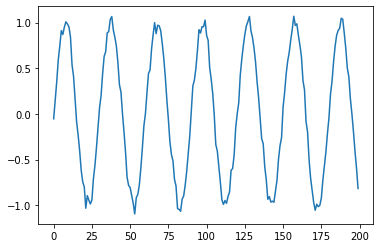

In [4]:
# Sample 3,000 points in [-10, 10], ratio = 1/150
base = np.linspace(-10, 10, 3000)
# Sine wave with a period of 30
T = 30
# Angular frequency, (* 150) due to the sampling density
w = 2 * np.pi / T * 150
x = np.sin(w * base) + np.random.normal(0, 0.05, 3000)
plt.plot(x[:200])
plt.show()

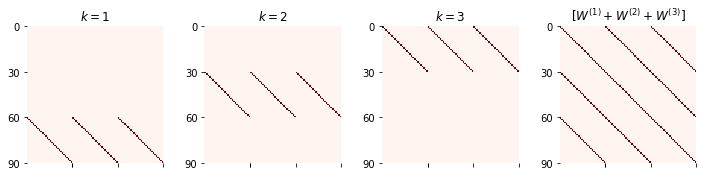

In [5]:
'''
    p: period
    k: factor
    n: input horizon
    m: prediction horizon
'''
def calculate_W(p, k, n, m):
    W = np.zeros((n, m))
    assert n >= p * k
    for j in range(m):
        for i in range(n):
            if i == n - k * p + (j % p):
                W[i][j] = 1

    return W

W_1 = calculate_W(T, 1, 90, 90)
W_2 = calculate_W(T, 2, 90, 90)
W_3 = calculate_W(T, 3, 90, 90)

plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
ax1 = sns.heatmap(W_1, square=True, cbar=False, cmap='Reds')
ax1.set_xticks([30, 30, 60, 90])
ax1.set_yticks([0, 30, 60, 90])
ax1.set_yticklabels([0, 30, 60, 90])
ax1.set_title('$k=1$')

plt.subplot(1, 4, 2)
ax2 = sns.heatmap(W_2, square=True, cbar=False, cmap='Reds')
ax2.set_xticks([30, 30, 60, 90])
ax2.set_yticks([0, 30, 60, 90])
ax2.set_yticklabels([0, 30, 60, 90])
ax2.set_title('$k=2$')

plt.subplot(1, 4, 3)
ax3 = sns.heatmap(W_3, square=True, cbar=False, cmap='Reds')
ax3.set_xticks([30, 30, 60, 90])
ax3.set_yticks([0, 30, 60, 90])
ax3.set_yticklabels([0, 30, 60, 90])
ax3.set_title('$k=3$')

plt.subplot(1, 4, 4)
ax4 = sns.heatmap(W_1 + W_2 + W_3, square=True, cbar=False, cmap='Reds')
ax4.set_xticks([30, 30, 60, 90])
ax4.set_yticks([0, 30, 60, 90])
ax4.set_yticklabels([0, 30, 60, 90])
ax4.set_title('$[W^{(1)}+W^{(2)}+W^{(3)}]$')

plt.subplots_adjust(wspace=0.3)
plt.show()

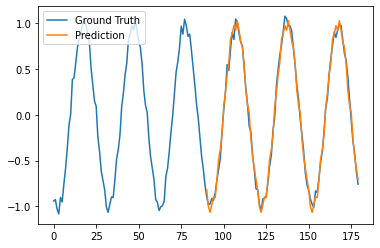

In [6]:
start = 500
his, true = x[start:start+90], x[start:start+180]
pred = np.matmul(his, W_2)
plt.plot(x[start:start+180], label='Ground Truth')
plt.plot([_+90 for _ in range(90)], pred, label='Prediction')
plt.legend(loc='upper left')
plt.show()

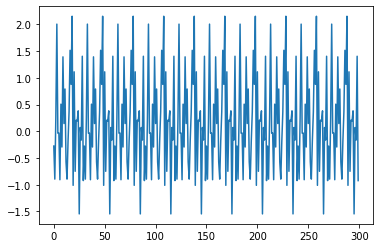

In [7]:
# Gaussian noise with a priod of 30
x = np.tile(np.random.normal(0, 1, 30), 10)
plt.plot(x)
plt.show()

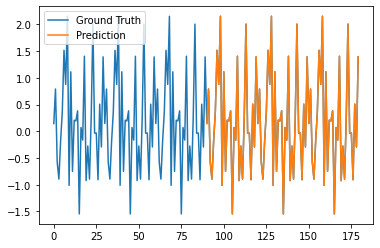

In [8]:
# The prediction results are only related to the period
start = 100
his, true = x[start:start+90], x[start:start+180]
pred = np.matmul(his, (W_1 + W_2 + W_3) / 3)
plt.plot(x[start:start+180], label='Ground Truth')
plt.plot([_+90 for _ in range(90)], pred, label='Prediction')
plt.legend(loc='upper left')
plt.show()